In [8]:
import json
from pycocotools.coco import COCO

# 原始注释文件路径
annotation_file = 'archive/turtles-data/data/annotations.json'
coco = COCO(annotation_file)

# 必需的类别
required_categories = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(required_categories, cat_ids))

# 统计缺失标签的图像ID
valid_image_ids = []
for img_id in coco.getImgIds():
    has_all_labels = True
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:  # 如果缺少该类别标签
            has_all_labels = False
            break
    if has_all_labels:
        valid_image_ids.append(img_id)

# 创建一个新的注释字典，只包含标签完整的图像和标注
filtered_annotations = {
    "images": [img for img in coco.dataset["images"] if img["id"] in valid_image_ids],
    "annotations": [ann for ann in coco.dataset["annotations"] if ann["image_id"] in valid_image_ids],
    "categories": coco.dataset["categories"]
}

# 保存过滤后的注释文件
filtered_annotation_file = 'archive/turtles-data/data/filtered_annotations.json'
with open(filtered_annotation_file, 'w') as f:
    json.dump(filtered_annotations, f)
print(f"Filtered annotations saved to {filtered_annotation_file}")

# 验证过滤结果
filtered_coco = COCO(filtered_annotation_file)
missing_labels_images = {category: 0 for category in required_categories}

for img_id in filtered_coco.getImgIds():
    for category, cat_id in cat_ids_map.items():
        ann_ids = filtered_coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:
            missing_labels_images[category] += 1
            break

# 输出验证结果
print("\nValidation of filtered dataset:")
for category, count in missing_labels_images.items():
    print(f"Number of images missing '{category}' label after filtering: {count}")


loading annotations into memory...
Done (t=4.66s)
creating index...
index created!
Filtered annotations saved to archive/turtles-data/data/filtered_annotations.json
loading annotations into memory...
Done (t=3.72s)
creating index...
index created!

Validation of filtered dataset:
Number of images missing 'turtle' label after filtering: 0
Number of images missing 'head' label after filtering: 0
Number of images missing 'flipper' label after filtering: 0


loading annotations into memory...
Done (t=1.59s)
creating index...
index created!


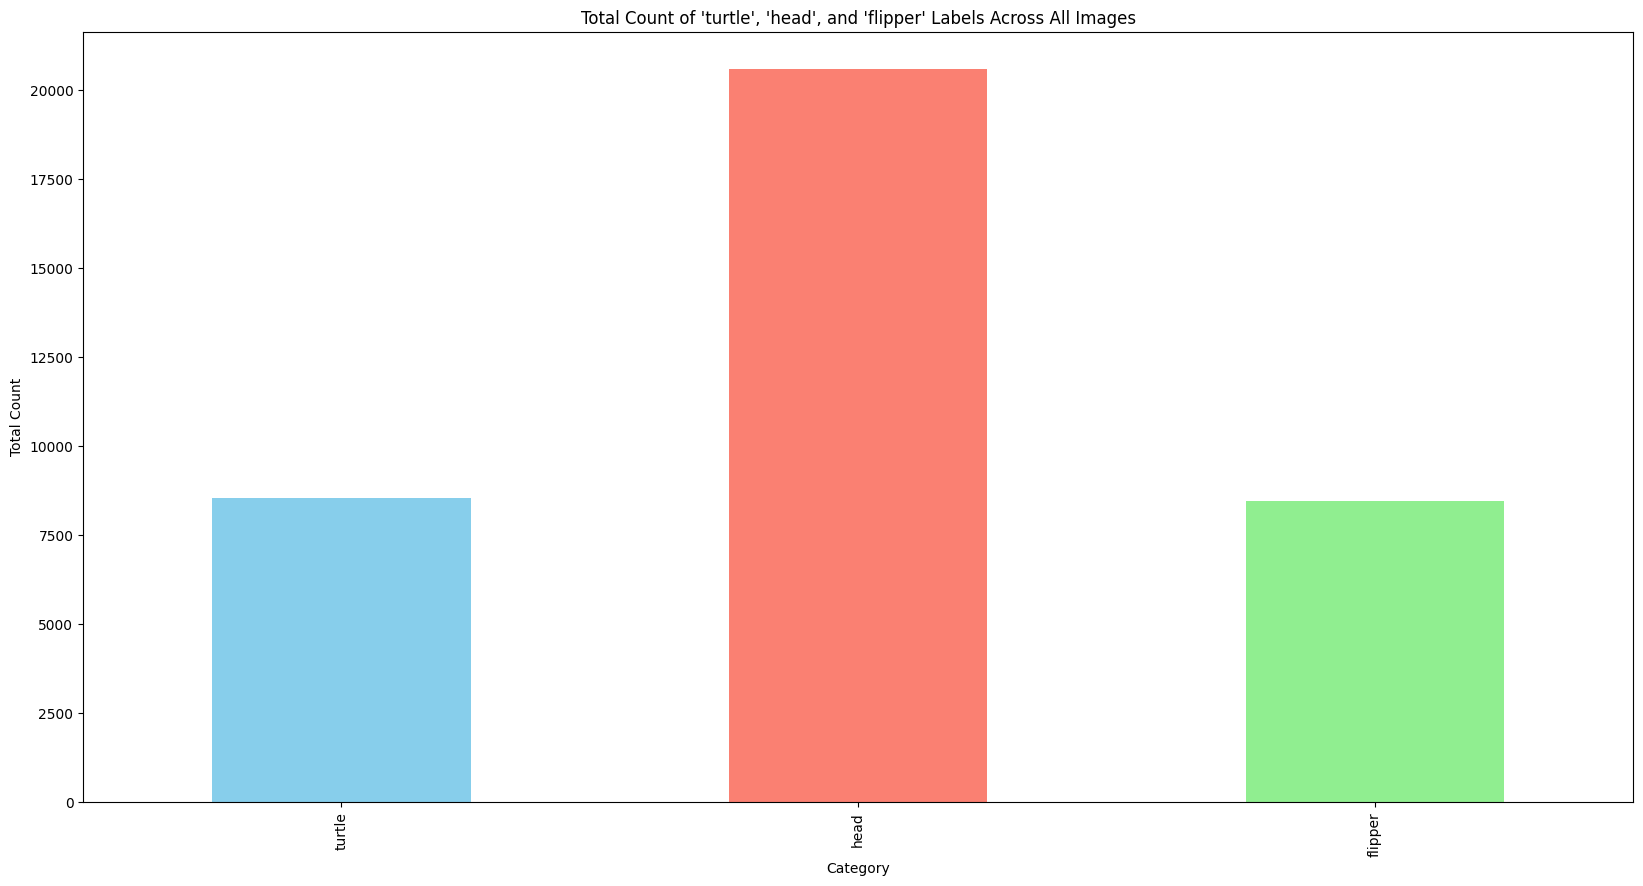

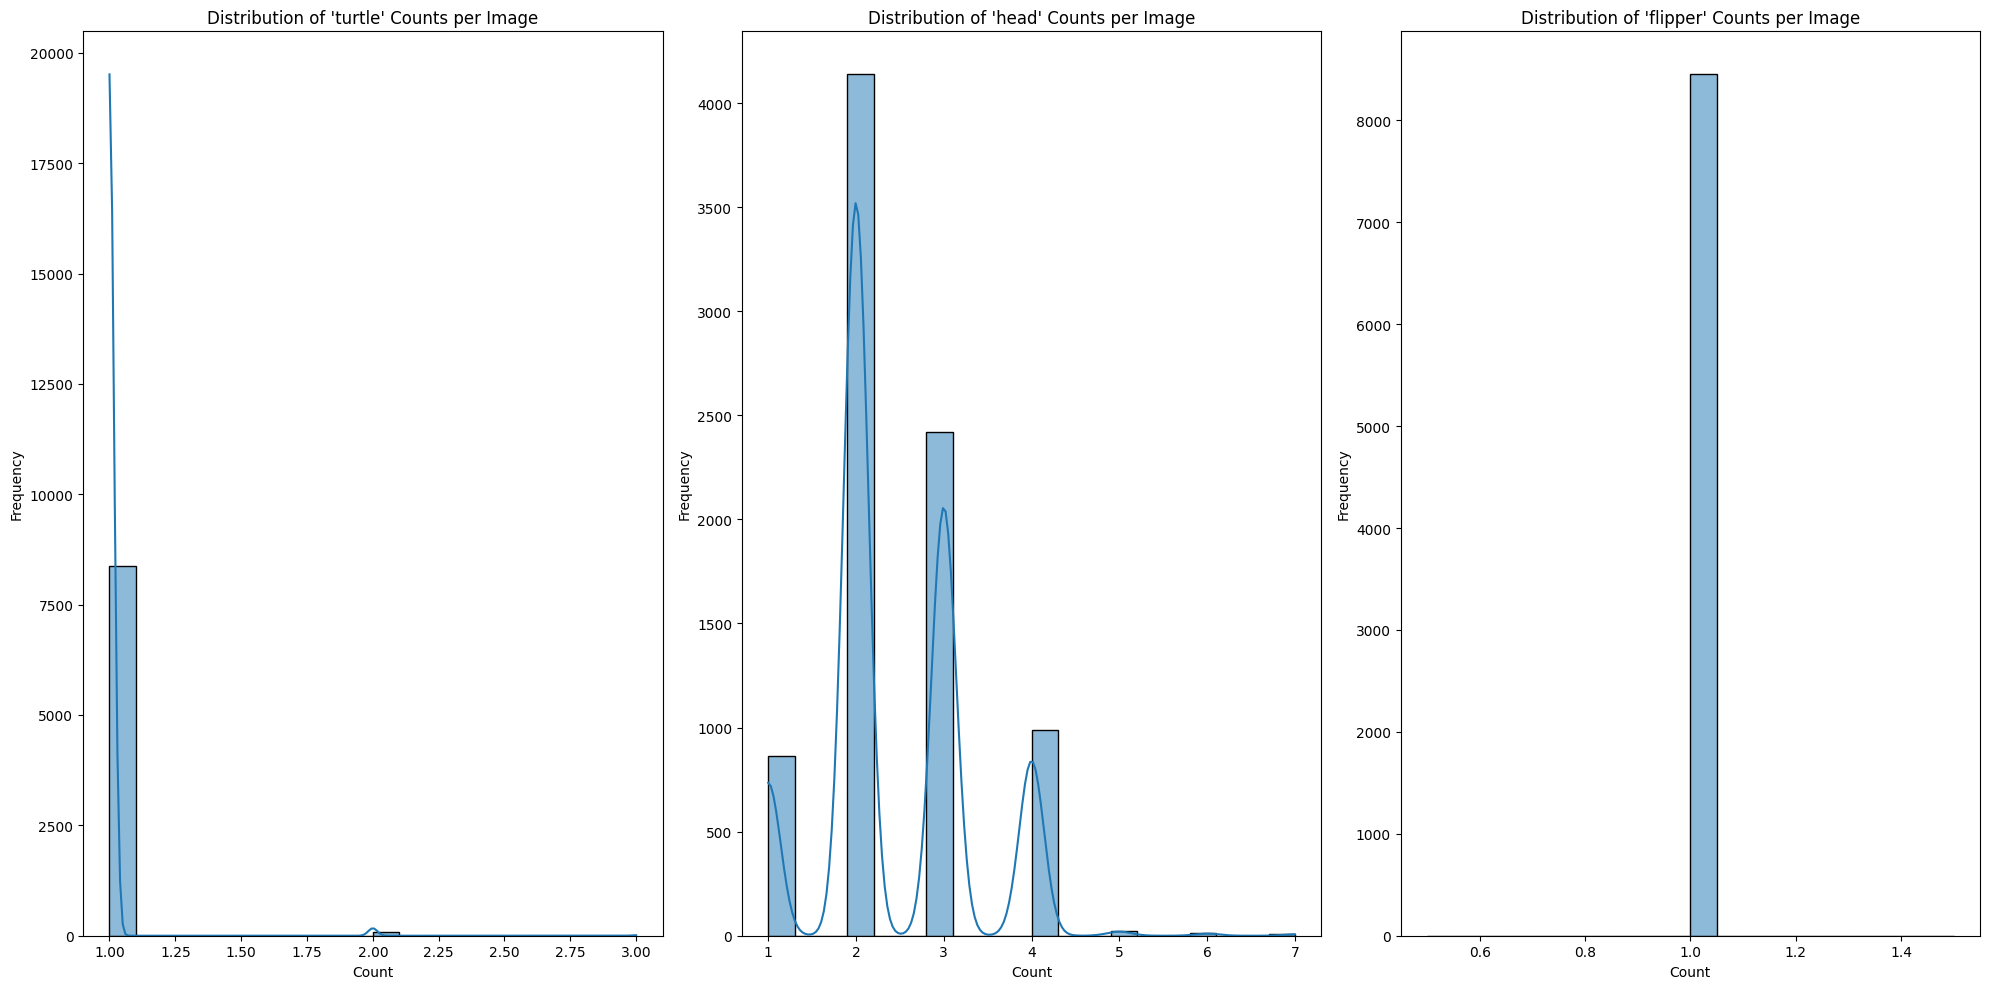

In [9]:
annotation_file = 'archive/turtles-data/data/filtered_annotations.json'
coco = COCO(annotation_file)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


category_names = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=category_names)

# Create a dictionary to count how many counts of each category there are in each image
category_counts = {'image_id': [], 'turtle': [], 'head': [], 'flipper': []}

# Loop over each image
img_ids = coco.getImgIds()
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)

    # Append the current image ID
    category_counts["image_id"].append(img_id)

    # Count number of each category for current image ID
    category_counts["turtle"].append(
        sum(ann["category_id"] == cat_ids[0] for ann in anns)
    )
    category_counts["head"].append(
        sum(ann["category_id"] == cat_ids[1] for ann in anns)
    )
    category_counts["flipper"].append(
        sum(ann["category_id"] == cat_ids[2] for ann in anns)
    )

# Convert to dataframe
category_counts_df = pd.DataFrame(category_counts)
category_sums = category_counts_df[["turtle", "head", "flipper"]].sum()

# Totals for each category
plt.figure(figsize=(20, 10))
category_sums.plot(kind="bar", color=["skyblue", "salmon", "lightgreen"])
plt.title("Total Count of 'turtle', 'head', and 'flipper' Labels Across All Images")
plt.xlabel("Category")
plt.ylabel("Total Count")
plt.show()

plt.figure(figsize=(20, 10))
for i, category in enumerate(["turtle", "head", "flipper"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(category_counts_df[category], kde=True, bins=20)
    plt.title(f"Distribution of '{category}' Counts per Image")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [10]:

required_categories = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(category_names, cat_ids))

missing_labels_images = {category: 0 for category in required_categories}
img_ids = coco.getImgIds()

for img_id in img_ids:
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:
            missing_labels_images[category] += 1
            break

for category, count in missing_labels_images.items():
    print(f"\nNumber of images missing '{category}' label: {count}")


Number of images missing 'turtle' label: 0

Number of images missing 'head' label: 0

Number of images missing 'flipper' label: 0


In [11]:
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO

# 加载COCO数据集
# annotation_file = 'path/to/annotations.json'  # 修改为实际的标注文件路径
coco = COCO(annotation_file)

required_categories = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(required_categories, cat_ids))

# 初始化字典，用于记录缺失标签的图像ID
missing_labels_images = {category: [] for category in required_categories}
img_ids = coco.getImgIds()

# 遍历每张图像，检查每个类别的标注是否缺失
for img_id in img_ids:
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        # 如果某类别标注缺失且数量少于10，则添加图像ID
        if not ann_ids and len(missing_labels_images[category]) < 10:
            missing_labels_images[category].append(img_id)
            break

# 显示缺失标签的图像
for category, img_list in missing_labels_images.items():
    print(f"\nImages missing '{category}' label (up to 10 images):")
    for img_id in img_list:
        # 加载图像信息和路径
        img_info = coco.loadImgs(img_id)[0]
        image_path = 'archive/turtles-data/data/' + img_info['file_name']  # 修改为实际的图像目录
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式

        # 显示图像
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Image ID: {img_id} - Missing '{category}' label")
        plt.axis('off')
        plt.show()

loading annotations into memory...
Done (t=1.72s)
creating index...
index created!

Images missing 'turtle' label (up to 10 images):

Images missing 'head' label (up to 10 images):

Images missing 'flipper' label (up to 10 images):
